In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

import tensorflow as tf
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics

# import wandb
# from wandb.keras import WandbCallback

In [3]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


Referencing: https://arxiv.org/pdf/2212.11285.pdf

We start off by loading in 1,000,000 background dijet events and 100,000 signal dijet events. The signal comes from the process Z$\rightarrow$ X($\rightarrow$ $q\bar{q}$) Y$\rightarrow$($q\bar{q}$) where Z is 3.5 TeV. X is 500 GeV and Y is 100 GeV. 

In [3]:
dir_path = "/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5"
df_test = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5")
df_test

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,0.372368,-1.283898,2.680089,0.511526,-0.216247,1.011824,0.440795,-1.860590,1.395164,1.483386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099996,0.587996,-2.347485,0.104980,0.325682,-1.943584,-2.330028,0.700224,-2.161175,0.136797,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099997,0.631419,-0.597308,-2.114541,3.165008,-0.968924,-0.729551,4.613834,-0.989630,-0.724770,3.701483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099998,5.084272,-1.004487,1.772670,4.767743,-0.878143,1.713857,10.833469,-0.934815,1.795471,10.265807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
df_QCD

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1467.239990,611.502014,511.101990,38.896000,8.290650,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042180,6.335090,5.525370
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788500,6.890140,5.813400,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,-646.442017,-1295.150024,1331.800049,37.011299,21.006800,12.873700,8.898860,274.566986,1019.390015,-504.290985,90.375000,61.218800,20.514500,15.854600
999995,-286.550995,-1310.829956,-1510.910034,147.516998,60.997799,41.356201,28.225700,252.884995,1085.420044,759.314026,58.769901,42.276402,8.637120,7.852020
999996,918.562988,951.195984,-1622.569946,32.242199,5.894110,5.004100,3.992740,-266.285004,-1284.189941,185.007996,136.389008,70.623901,49.508499,40.708599
999997,1447.219971,-547.710999,827.945007,396.112000,181.406998,152.207993,86.676804,-932.369995,165.005005,-2806.959961,56.471600,14.446400,10.258900,8.874700


In [10]:
df = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")

In [16]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


Text(0.5, 1.0, 'Jet Mass Distributions')

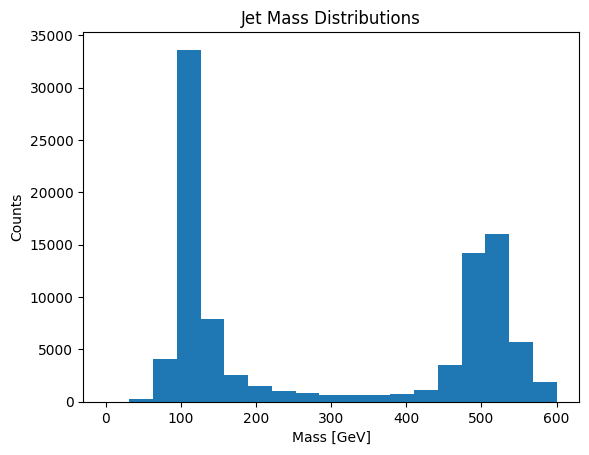

In [65]:
plt.hist(df['mj1'],bins=np.linspace(0,600,20))
plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.title("Jet Mass Distributions")

In [13]:
def computemjj_pd(event):
    px1 = event[["pxj1"]].to_numpy()
    py1 = event[["pyj1"]].to_numpy()
    pz1 = event[["pzj1"]].to_numpy()
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
    px2 = event[["pxj2"]].to_numpy()
    py2 = event[["pyj2"]].to_numpy()
    pz2 = event[["pzj2"]].to_numpy()
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[["mj2"]].to_numpy()**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [22]:
computemjj_pd(df_QCD)

array([3307.21938744, 3107.62060343, 3004.89527209, ..., 3021.08344341,
       4283.54500244, 2784.05801619])

In [14]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [15]:
mj1_list = []
mj2_list = []
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

epsilon = 1e-4
if (True):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    sd_m = 0.
    sd_t = 0.

    for m1 in mass_range:
        for m2 in mass_range:

            print("on ...",m1,m2)

            ltau1_m_m = []
            ltau2_m_m = []
            stau1_m_m = []
            stau2_m_m = []
            if (m1>0 and m2>0):
                myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq_fixed/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                jets_m_m = []
                for line in myfile:
                    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                    pass
                                    
                ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

                #check ordering of the leading and subleading jets
                #if leading jet mm > subleading, continue
                #if leading jet mm < subleading, swap
                for i in range(int(len(lmass_m_m))):
                    if lmass_m_m[i] > smass_m_m[i]:
                        continue
                    elif lmass_m_m[i] < smass_m_m[i]:
                        lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                
                ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])

                stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])

                mjj = computemjj_txt(jets_m_m)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]
                pass
            elif m1==0 and m2==0:
                df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                
                #check jet ordering
                for i in range(int(len(lmass_m_m))):
                    if lmass_m_m[i] > smass_m_m[i]:
                        continue
                    elif lmass_m_m[i] < smass_m_m[i]:
                        lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                mjj = computemjj_pd(df_QCD)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]

                mu_m = np.mean(lmass_m_m)
                mu_t = np.mean(ltau2_m_m/(ltau1_m_m+0.0001))
                sd_m = np.std(lmass_m_m)
                sd_t = np.std(ltau2_m_m/(ltau1_m_m+0.0001))
                pass
            else:
                continue

            ms = np.stack([lmass_m_m,smass_m_m],axis=1)
            ts = np.stack([ltau2_m_m/(ltau1_m_m+0.0001),stau2_m_m/(stau1_m_m+0.0001)],axis=1)
            order1 = [np.argmax(ms[i]) for i in range(len(ms))]
            order2 = [np.argmin(ms[i]) for i in range(len(ms))]
            mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
            mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
            
            #testing to see if jets sorted properly
            mj1_list.append(mJ1)
            mj2_list.append(mJ2)
            
            x[m1,m2] = np.stack([(mJ2 - mu_m)/sd_m,
                                    ((mJ1 - mJ2) - mu_m)/sd_m,
                                    ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                    ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t],axis=1)
            lmass_vec[m1,m2]=lmass_m_m
            pass
        pass

    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            x_array+=[x[m1,m2]]
    np.save("x_array_4FeatureFixed", x_array)

on ... 0 0
on ... 0 0.5
on ... 0 1
on ... 0 1.5
on ... 0 2
on ... 0 2.5
on ... 0 3
on ... 0 3.5
on ... 0 4
on ... 0 4.5
on ... 0 5
on ... 0 5.5
on ... 0 6
on ... 0.5 0
on ... 0.5 0.5
on ... 0.5 1
on ... 0.5 1.5
on ... 0.5 2
on ... 0.5 2.5
on ... 0.5 3
on ... 0.5 3.5
on ... 0.5 4
on ... 0.5 4.5
on ... 0.5 5
on ... 0.5 5.5
on ... 0.5 6
on ... 1 0
on ... 1 0.5
on ... 1 1
on ... 1 1.5
on ... 1 2
on ... 1 2.5
on ... 1 3
on ... 1 3.5
on ... 1 4
on ... 1 4.5
on ... 1 5
on ... 1 5.5
on ... 1 6
on ... 1.5 0
on ... 1.5 0.5
on ... 1.5 1
on ... 1.5 1.5
on ... 1.5 2
on ... 1.5 2.5
on ... 1.5 3
on ... 1.5 3.5
on ... 1.5 4
on ... 1.5 4.5
on ... 1.5 5
on ... 1.5 5.5
on ... 1.5 6
on ... 2 0
on ... 2 0.5
on ... 2 1
on ... 2 1.5
on ... 2 2
on ... 2 2.5
on ... 2 3
on ... 2 3.5
on ... 2 4
on ... 2 4.5
on ... 2 5
on ... 2 5.5
on ... 2 6
on ... 2.5 0
on ... 2.5 0.5
on ... 2.5 1
on ... 2.5 1.5
on ... 2.5 2
on ... 2.5 2.5
on ... 2.5 3
on ... 2.5 3.5
on ... 2.5 4
on ... 2.5 4.5
on ... 2.5 5
on ... 2.5 5.5
on ..

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [34]:
#np.save("x_array_order", x_array)

/global/common/software/nersc/pm-2022q4/sw/tensorflow/2.9.0/lib/python3.9/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [3]:
#check if jets sorted properly
count = 0
for i in range(len(mj1_list)):
    for j in range(len(mj1_list[i])):
        if mj1_list[i][j] < mj2_list[i][j]:
            #print("greater")
            count+=1
print(f"{count} instances of mj1 < mj2")

In [4]:
qq = "qq"
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]
def load_data(filename, noise_dims):

    x = {}
    x_array_read = np.load(filename,allow_pickle=True)
    mycounter = -1
    for m1 in mass_range:
        for m2 in mass_range:
            for qq in ['qq']:
                if (m1==0 and m2>0 or m2==0 and m1>0):
                    continue
                mycounter+=1
                x[m1,m2,qq, False] = x_array_read[mycounter]

                if noise_dims:
                    qq = "qq"
                    for i in range(noise_dims):
                        noise_feature = np.random.normal(0, 1, len(x[m1,m2,qq, False])).reshape(-1, 1)
                        if i == 0:
                            x[m1, m2, qq, True] = np.hstack((x[m1,m2, qq, False], noise_feature))
                        if i > 0:
                            x[m1, m2, qq, True] = np.hstack((x[m1,m2, qq, True], noise_feature))
    
    return x
            
x = load_data("x_array_4FeatureFixed.npy", noise_dims = 0)

In [5]:
x[1, 1, qq, False]

array([[-1.1467854 , -1.47770924, -0.013095  , -1.25308806],
       [-1.1487145 , -1.69706728, -0.65093383,  0.03500569],
       [-1.13268386, -1.55028145, -1.32760465, -0.39714657],
       ...,
       [-1.17579285, -1.62957953, -0.72623478, -1.31430044],
       [-1.19046974, -1.71033063, -0.39640732,  0.11360652],
       [-1.23125368, -1.64679808, -1.98019215, -1.64119963]])

In [4]:
np.shape(x[5, 1, qq, False])

(58176, 4)

In [24]:
np.shape(x[0,0, "qq", False])

(121352, 4)

In [14]:
qq = "qq"
x_data = np.concatenate([x[0,0, qq, False],x[1,1, qq, False]])
y_data = np.concatenate([np.zeros(len(x[0,0, qq, False])),np.ones(len(x[1,1, qq, False]))])
X_train, X_val, Y_train, Y_val = train_test_split(x_data, y_data, test_size=0.5)

In [117]:
y_val_pred = model_dedicated.predict(X_val)
auc = roc_auc_score(Y_val, y_val_pred)

print("AUC:", auc)

2806/2806 [==============================] - 2s 754us/step
AUC: 0.9696640331901925


In [15]:
model_dedicated = Sequential()
model_dedicated.add(Dense(128, input_dim=4, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(1, activation='sigmoid'))
model_dedicated.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

In [16]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
myhistory = model_dedicated.fit(X_train, Y_train, epochs=100,validation_data=(X_val, Y_val),batch_size=1024, callbacks = [es])

Epoch 1/100
97/97 [==============================] - 3s 9ms/step - loss: 0.3494 - accuracy: 0.8535 - val_loss: 0.2774 - val_accuracy: 0.8881
Epoch 2/100
97/97 [==============================] - 1s 7ms/step - loss: 0.2599 - accuracy: 0.8941 - val_loss: 0.2532 - val_accuracy: 0.8949
Epoch 3/100
97/97 [==============================] - 1s 6ms/step - loss: 0.2410 - accuracy: 0.9019 - val_loss: 0.2338 - val_accuracy: 0.9044
Epoch 4/100
97/97 [==============================] - 1s 6ms/step - loss: 0.2246 - accuracy: 0.9075 - val_loss: 0.2156 - val_accuracy: 0.9112
Epoch 5/100
97/97 [==============================] - 1s 12ms/step - loss: 0.2078 - accuracy: 0.9145 - val_loss: 0.2073 - val_accuracy: 0.9137
Epoch 6/100
97/97 [==============================] - 1s 8ms/step - loss: 0.2025 - accuracy: 0.9165 - val_loss: 0.2016 - val_accuracy: 0.9158
Epoch 7/100
97/97 [==============================] - 1s 7ms/step - loss: 0.2008 - accuracy: 0.9172 - val_loss: 0.2007 - val_accuracy: 0.9163
Epoch 8/100


In [31]:
preds_mm_list = []
tuple_rates_dedicated_fixed_BCE = {}

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

for i in mass_range[1:]:
    for j in mass_range[1:]:
        if (i == 0.5 and j == 0.5) or (i == 1 and j == 1) or (i == 2 and j == 2) or (i == 3 and j == 3) or (i == 4 and j == 4) or (i == 5 and j == 5) or (i == 6 and j == 6) or (i == 5 and j == 1) or (i == 3 and j == 4.5) or (i == 2 and j == 5):
            x_data_mm = np.concatenate([x[0,0, qq, False],x[i,j, qq, False]])
            y_data_mm = np.concatenate([np.zeros(len(x[0,0, qq, False])),np.ones(len(x[i,j, qq, False]))])
            X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_data_mm, y_data_mm, test_size=0.5)

            model = Sequential()
            model.add(Dense(512, input_dim=4, activation='relu'))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            myhistory = model.fit(X_train_mm, Y_train_mm, epochs=1000, validation_data=(X_val_mm, Y_val_mm),batch_size=1024, callbacks = [es])

            preds_mm = model.predict(X_val_mm,batch_size=1000)
            fpr_mm, tpr_mm, _ = metrics.roc_curve(Y_val_mm, preds_mm)

            preds_mm_list.append(preds_mm)
            tuple_rates_dedicated_fixed_BCE[tuple((i, j))] = [fpr_mm, tpr_mm]

Epoch 1/1000
97/97 [==============================] - 1s 3ms/step - loss: 0.3625 - accuracy: 0.8380 - val_loss: 0.3047 - val_accuracy: 0.8660
Epoch 2/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.3011 - accuracy: 0.8679 - val_loss: 0.3508 - val_accuracy: 0.8429
Epoch 3/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.3046 - accuracy: 0.8649 - val_loss: 0.2984 - val_accuracy: 0.8657
Epoch 4/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.2942 - accuracy: 0.8695 - val_loss: 0.2892 - val_accuracy: 0.8715
Epoch 5/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.2909 - accuracy: 0.8709 - val_loss: 0.2916 - val_accuracy: 0.8720
Epoch 6/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.2905 - accuracy: 0.8717 - val_loss: 0.3463 - val_accuracy: 0.8413
Epoch 7/1000
97/97 [==============================] - 0s 2ms/step - loss: 0.2985 - accuracy: 0.8669 - val_loss: 0.2847 - val_accuracy: 0.8739
Epoch 

In [7]:
len(tuple_rates_dedicated_fixed_BCE)

7

In [36]:
#np.save("tuple_rates_dedicated_fixed_BCE", tuple_rates_dedicated_fixed_BCE)

In [8]:
model_all = tf.keras.models.load_model('/pscratch/sd/g/gupsingh/enthusiastic-hug-584Feature')

In [15]:
tuple_rates_dedicated = np.load("tuple_rates_dedicated_fixed.npy", allow_pickle = True).item()
len(tuple_rates_dedicated)

10

In [40]:
tuple_rates_dedicated.keys()

dict_keys([(0.5, 0.5), (1, 1), (2, 2), (2, 5), (3, 3), (3, 4.5), (4, 4), (5, 1), (5, 5), (6, 6)])

180/180 [==============================] - 0s 749us/step


/tmp/ipykernel_1051301/289555422.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all, 1/(fpr_all), label = f"{m1_try*100} {m2_try*100}", linewidth = 1)


180/180 [==============================] - 0s 747us/step


/tmp/ipykernel_1051301/289555422.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all, 1/(fpr_all), label = f"{m1_try*100} {m2_try*100}", linewidth = 1)


180/180 [==============================] - 0s 730us/step


/tmp/ipykernel_1051301/289555422.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all, 1/(fpr_all), label = f"{m1_try*100} {m2_try*100}", linewidth = 1)


180/180 [==============================] - 0s 794us/step


/tmp/ipykernel_1051301/289555422.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all, 1/(fpr_all), label = f"{m1_try*100} {m2_try*100}", linewidth = 1)


180/180 [==============================] - 0s 734us/step


/tmp/ipykernel_1051301/289555422.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all, 1/(fpr_all), label = f"{m1_try*100} {m2_try*100}", linewidth = 1)
/global/homes/g/gupsingh/.local/perlmutter/tensorflow2.9.0/lib/python3.9/site-packages/slack_sdk/web/internal_utils.py:417: UserWarning: client.files_upload() may cause some issues like timeouts for relatively large files. Our latest recommendation is to use client.files_upload_v2(), which is mostly compatible and much stabler, instead.
  warnings.warn(message)


Plot sent successfully: None


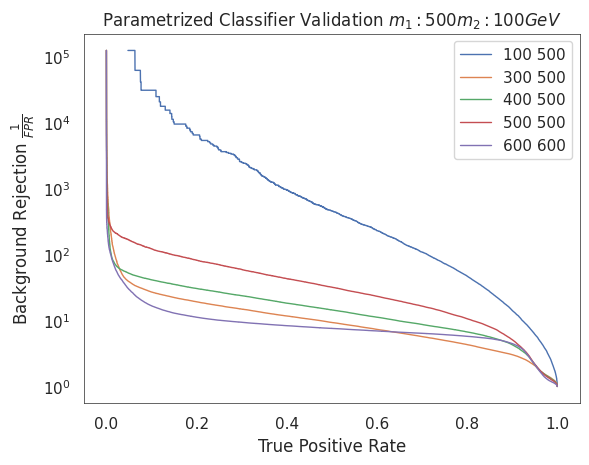

In [35]:
import seaborn as sns
from utils import send_slack_plot 
#epsilon = 1e-4
m1 = 5
m2 = 1

#takes parametrized data corresponding to m1,m2 and replaces it with wrong masses
#then evaluates the data on trained parametrized model
def validation_plot(m1, m2):
    m1_masses_to_try = [1, 3, 4, 5, 6]
    m2_masses_to_try = [5, 5, 5, 5, 6]
    for m1_try, m2_try in zip(m1_masses_to_try, m2_masses_to_try):
        parametrized_data = x_data_all[np.product(x_data_all[:,4:6]==[m1,m2],axis=1)==1]
        parametrized_data[:,4:6]= np.c_[np.ones(len(parametrized_data)) * m1_try, np.ones(len(parametrized_data)) * m2_try]
        preds_parametrized = model_all.predict(parametrized_data,batch_size=1000)
        fpr_all, tpr_all, _ = metrics.roc_curve(y_data_all[np.product(x_data_all[:,4:6]==[m1,m2],axis=1)==1], preds_parametrized)
        plt.plot(tpr_all, 1/(fpr_all), label = f"{m1_try*100} {m2_try*100}", linewidth = 1)
        plt.legend()
        plt.title(f"Parametrized Classifier Validation $m_{1}: {m1*100}  m_{2}: {m2*100} GeV$")
        plt.xlabel("True Positive Rate")
        plt.ylabel("Background Rejection $\\frac{1}{FPR}$")
        sns.set(style="white")
        plt.gca().spines['top'].set_linewidth(0.5)
        plt.gca().spines['right'].set_linewidth(0.5)
        plt.gca().spines['bottom'].set_linewidth(0.5)
        plt.gca().spines['left'].set_linewidth(0.5)
        plt.yscale("log")
    img_path = f"plots/validationplot{float(m1)}{float(m2)}.png"
    plt.savefig(img_path, dpi=450, bbox_inches='tight')
    send_slack_plot(img_path)
    
validation_plot(m1,m2)

In [88]:
for m in [2, 3, 4, 5.5, 6]:
    something = x_data_all[np.product(x_data_all[:,4:6]==[4.5,6],axis=1)==1]
    something[:,4:6]= np.c_[np.ones(len(something)) * m, np.ones(len(something)) * m]
    print(something[:,4:6])

[[2. 2.]
 [2. 2.]
 [2. 2.]
 ...
 [2. 2.]
 [2. 2.]
 [2. 2.]]
[[3. 3.]
 [3. 3.]
 [3. 3.]
 ...
 [3. 3.]
 [3. 3.]
 [3. 3.]]
[[4. 4.]
 [4. 4.]
 [4. 4.]
 ...
 [4. 4.]
 [4. 4.]
 [4. 4.]]
[[5.5 5.5]
 [5.5 5.5]
 [5.5 5.5]
 ...
 [5.5 5.5]
 [5.5 5.5]
 [5.5 5.5]]
[[6. 6.]
 [6. 6.]
 [6. 6.]
 ...
 [6. 6.]
 [6. 6.]
 [6. 6.]]


In [11]:
#evaluate parametrized model on all mass points, 
#return dicitonary of fpr and tpr for given mass pair
def eval_parametrized(model_parametrized):
    preds_parametrized_list = []
    tuples_rates_parametrized = {}
    for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:
            preds_parametrized = model_parametrized.predict(x_data_all[np.product(x_data_all[:,4:6]==[m1,m2],axis=1)==1],batch_size=1000)
            fpr_parametrized, tpr_parametrized, _ = metrics.roc_curve(y_data_all[np.product(x_data_all[:,4:6]==[m1,m2],axis=1)==1], preds_parametrized)

            preds_parametrized_list.append(preds_parametrized)
            tuples_rates_parametrized[tuple((m1, m2))] = [fpr_parametrized, tpr_parametrized]
    np.save("tuples_rates_parametrized.npy", tuples_rates_parametrized)
    return tuples_rates_parametrized

eval_parametrized(model_all)

130/197 [==================>...........] - ETA: 0s

2024-02-16 13:29:53.545275: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


175/175 [==============================] - 0s 773us/step


{(0.5,
  0.5): [array([0.        , 0.        , 0.        , ..., 0.96663425, 0.96665074,
         1.        ]), array([0.00000000e+00, 1.32826820e-05, 1.14231066e-03, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00])],
 (0.5,
  1): [array([0.        , 0.        , 0.        , ..., 0.96787857, 0.96789505,
         1.        ]), array([0.00000000e+00, 1.31015237e-05, 4.06147235e-04, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00])],
 (0.5,
  1.5): [array([0.        , 0.        , 0.        , ..., 0.97312776, 0.97314424,
         1.        ]), array([0.00000000e+00, 1.30749719e-05, 8.76023117e-04, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00])],
 (0.5,
  2): [array([0.        , 0.        , 0.        , ..., 0.99803876, 0.99805524,
         1.        ]), array([0.00000000e+00, 1.31475151e-05, 3.54982908e-04, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00])],
 (0.5,
  2.5): [array([0.        , 0.        , 0.        , ..., 0.98580988, 0.98

/tmp/ipykernel_1051301/4274011567.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tuple_rates_dedicated[(m1,m2)][1], 1./(tuple_rates_dedicated[(m1,m2)][0]), label = f"{m1*100}, {m2*100} GEV")
/tmp/ipykernel_1051301/4274011567.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tuple_rates_parametrized[(m1, m2)][1], 1./(tuple_rates_parametrized[(m1, m2)][0]),label= f"Parameterized {m1*100} {m2*100} GEV", linestyle='dashed')


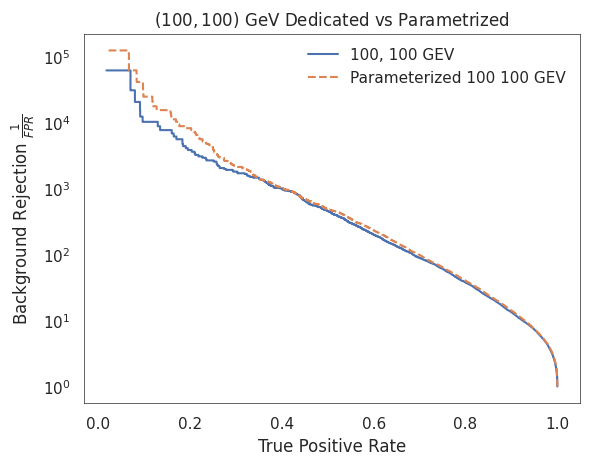

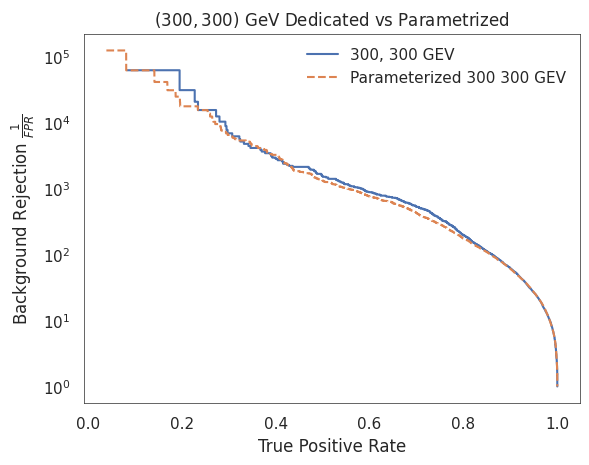

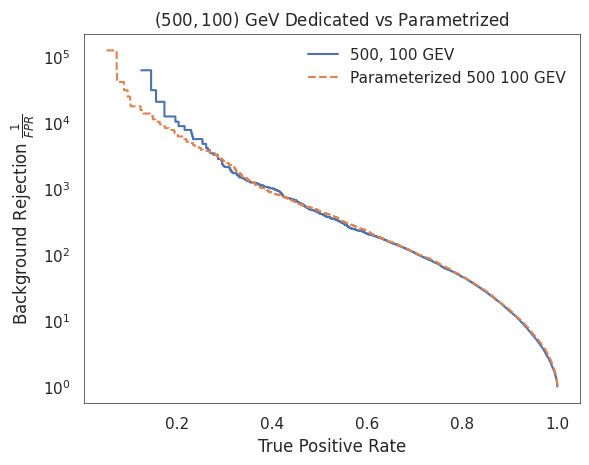

In [20]:
epsilon = 1e-4

def plot_comparison(m1, m2):
    tuple_rates_parametrized = np.load("tuples_rates_parametrized.npy", allow_pickle = True).item()
    tuple_rates_dedicated = np.load("tuple_rates_dedicated_fixed.npy", allow_pickle = True).item()
    plt.figure()
    plt.plot(tuple_rates_dedicated[(m1,m2)][1], 1./(tuple_rates_dedicated[(m1,m2)][0]), label = f"{m1*100}, {m2*100} GEV")
    plt.plot(tuple_rates_parametrized[(m1, m2)][1], 1./(tuple_rates_parametrized[(m1, m2)][0]),label= f"Parameterized {m1*100} {m2*100} GEV", linestyle='dashed')
    plt.yscale("log")
    plt.legend(frameon=False)
    plt.xlabel("True Positive Rate")
    plt.ylabel("Background Rejection $\\frac{1}{FPR}$")
    plt.title(f"$({m1*100}, {m2*100})$ GeV Dedicated vs Parametrized")
    sns.set(style="white")
    plt.gca().spines['top'].set_linewidth(0.5)
    plt.gca().spines['right'].set_linewidth(0.5)
    plt.gca().spines['bottom'].set_linewidth(0.5)
    plt.gca().spines['left'].set_linewidth(0.5)
    plt.show()

plot_comparison(1, 1)
plot_comparison(3, 3)
plot_comparison(5, 1)

Analysis of Models begins here

In [40]:
if (True):
    x_data_all = []
    y_data_all = []
    for m1 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            #if m1 >= m2: 
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1),m2*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2],m1*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_all = np.concatenate([x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_vals_all = np.concatenate([x_vals_all,x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([y_vals_all,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
    # np.save("x_data_all_fixed",x_vals_all)
    # np.save("y_data_all_fixed",y_vals_all)

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [17]:
#with noise
noise = False
if (True):
    x_data_all = []
    y_data_all = []
    for m1 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            for qq in ['qq']:
                print(m1,m2)
                x_aug_0 = np.append(np.append(x[0,0,qq, noise],m1*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[0,0,qq, noise])),[len(x[0,0,qq, noise]),1]),1)
                x_aug_m = np.append(np.append(x[m1,m2,qq, noise],m1*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2,qq, noise])),[len(x[m1,m2,qq, noise]),1]),1)
                if (m1==0.5 and m2==0.5):
                    x_data_all = np.concatenate([x_aug_0,x_aug_m])
                    y_data_all = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
                else:
                    x_data_all = np.concatenate([x_data_all,x_aug_0,x_aug_m])
                    y_data_all = np.concatenate([y_data_all,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
    np.save("data/4Feature_x_data_all_fixed",x_data_all)
    np.save("data/4Feature_y_data_all_fixed",y_data_all)

0.5 0.5
0.5 1
0.5 1.5
0.5 2
0.5 2.5
0.5 3
0.5 3.5
0.5 4
0.5 4.5
0.5 5
0.5 5.5
0.5 6
1 0.5
1 1
1 1.5
1 2
1 2.5
1 3
1 3.5
1 4
1 4.5
1 5
1 5.5
1 6
1.5 0.5
1.5 1
1.5 1.5
1.5 2
1.5 2.5
1.5 3
1.5 3.5
1.5 4
1.5 4.5
1.5 5
1.5 5.5
1.5 6
2 0.5
2 1
2 1.5
2 2
2 2.5
2 3
2 3.5
2 4
2 4.5
2 5
2 5.5
2 6
2.5 0.5
2.5 1
2.5 1.5
2.5 2
2.5 2.5
2.5 3
2.5 3.5
2.5 4
2.5 4.5
2.5 5
2.5 5.5
2.5 6
3 0.5
3 1
3 1.5
3 2
3 2.5
3 3
3 3.5
3 4
3 4.5
3 5
3 5.5
3 6
3.5 0.5
3.5 1
3.5 1.5
3.5 2
3.5 2.5
3.5 3
3.5 3.5
3.5 4
3.5 4.5
3.5 5
3.5 5.5
3.5 6
4 0.5
4 1
4 1.5
4 2
4 2.5
4 3
4 3.5
4 4
4 4.5
4 5
4 5.5
4 6
4.5 0.5
4.5 1
4.5 1.5
4.5 2
4.5 2.5
4.5 3
4.5 3.5
4.5 4
4.5 4.5
4.5 5
4.5 5.5
4.5 6
5 0.5
5 1
5 1.5
5 2
5 2.5
5 3
5 3.5
5 4
5 4.5
5 5
5 5.5
5 6
5.5 0.5
5.5 1
5.5 1.5
5.5 2
5.5 2.5
5.5 3
5.5 3.5
5.5 4
5.5 4.5
5.5 5
5.5 5.5
5.5 6
6 0.5
6 1
6 1.5
6 2
6 2.5
6 3
6 3.5
6 4
6 4.5
6 5
6 5.5
6 6


In [10]:
x_data_all = np.load("data/4Feature_x_data_all_fixed.npy")
y_data_all = np.load("data/4Feature_y_data_all_fixed.npy")

In [14]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(x_data_all, y_data_all, test_size=0.5, random_state = 42)

In [15]:
X_train_all

array([[-1.29067761, -1.49584945,  1.52319619,  0.7592459 ,  3.        ,
         4.5       ],
       [-0.9812558 , -0.0741258 , -1.56036847, -1.1920337 ,  1.        ,
         4.        ],
       [-1.5053652 , -1.46572857,  2.12340643,  1.2075631 ,  2.        ,
         5.5       ],
       ...,
       [-1.33821732,  0.60248958, -0.35902575, -0.36620014,  5.5       ,
         1.5       ],
       [-1.1929567 , -0.94234964, -0.89990215,  1.05254215,  3.5       ,
         6.        ],
       [-1.21768687, -0.23171448, -0.45548656,  1.16579113,  5.5       ,
         1.        ]])

In [11]:
import wandb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from wandb.keras import WandbCallback


pscratch_dir = "/pscratch/sd/g/gupsingh/"
os.environ["WANDB_DIR"] = pscratch_dir

config = {
    "layer_1_neurons": 256,
    "layer_2_neurons": 128,
    "layer_3_neurons": 64,
    "output_neurons": 1,
    "activation": "relu",
    "output_activation": "sigmoid",
    "optimizer": "adam",
    "learning_rate": 0.0001,
    "loss": "binary_crossentropy",
    "epochs": 5000,
    "batch_size": 1024
}

wandb.init(project="SemiWeakly", 
           group="Parametrized", 
           entity='gup-singh',
           mode = 'online',
           config=config)

config = wandb.config
run_name = wandb.run.name

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

def train_parametrized(X_train, Y_train, X_val, Y_val, config, return_history=False):
    model_parametrized = Sequential()
    model_parametrized.add(Dense(config["layer_1_neurons"], input_dim=np.shape(X_train)[1], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config["layer_2_neurons"], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config["layer_3_neurons"], activation=config["activation"]))
    model_parametrized.add(BatchNormalization())
    model_parametrized.add(Dense(config.output_neurons, activation=config["output_activation"]))
    model_parametrized.compile(loss=config["loss"], optimizer=tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]), metrics=['accuracy'])

    with tf.device('/GPU:0'):
        history_parametrized = model_parametrized.fit(X_train, Y_train, epochs=config.epochs, validation_data=(X_val, Y_val), batch_size=config.batch_size, callbacks=[es, WandbCallback()])
        
    if return_history:
        return model_parametrized, history_parametrized
    else:
        return model_parametrized

model_parametrized, history_parametrized = train_parametrized(X_train_all, Y_train_all, X_val_all, Y_val_all, config, return_history=True)

wandb.finish()

model_parametrized.save("4Feature/"+pscratch_dir + run_name)
#model_parametrized.save(pscratch_dir+"normal")
num_epochs = len(history_parametrized["loss"])
val_accuracy = history_parametrized.history['val_accuracy']
send_slack_message(f"Notebook Parametrized Training Finished - Epochs: {num_epochs} - Validation Accuracy: {val_accuracy}")

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Epoch 1/5000
13306/13306 [==============================] - ETA: 0s - loss: 0.1855 - accuracy: 0.9275INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.1s


13306/13306 [==============================] - 44s 3ms/step - loss: 0.1855 - accuracy: 0.9275 - val_loss: 0.1733 - val_accuracy: 0.9319
Epoch 2/5000
13303/13306 [============================>.] - ETA: 0s - loss: 0.1735 - accuracy: 0.9318INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 42s 3ms/step - loss: 0.1735 - accuracy: 0.9318 - val_loss: 0.1707 - val_accuracy: 0.9329
Epoch 3/5000
13298/13306 [============================>.] - ETA: 0s - loss: 0.1722 - accuracy: 0.9323INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 42s 3ms/step - loss: 0.1722 - accuracy: 0.9323 - val_loss: 0.1701 - val_accuracy: 0.9331
Epoch 4/5000
13294/13306 [============================>.] - ETA: 0s - loss: 0.1714 - accuracy: 0.9325INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 42s 3ms/step - loss: 0.1714 - accuracy: 0.9325 - val_loss: 0.1695 - val_accuracy: 0.9333
Epoch 5/5000
13306/13306 [==============================] - 41s 3ms/step - loss: 0.1709 - accuracy: 0.9328 - val_loss: 0.1696 - val_accuracy: 0.9333
Epoch 6/5000
13287/13306 [============================>.] - ETA: 0s - loss: 0.1705 - accuracy: 0.9329INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 46s 3ms/step - loss: 0.1705 - accuracy: 0.9329 - val_loss: 0.1690 - val_accuracy: 0.9335
Epoch 7/5000
13298/13306 [============================>.] - ETA: 0s - loss: 0.1702 - accuracy: 0.9330INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 43s 3ms/step - loss: 0.1702 - accuracy: 0.9330 - val_loss: 0.1687 - val_accuracy: 0.9336
Epoch 8/5000
13306/13306 [==============================] - 42s 3ms/step - loss: 0.1700 - accuracy: 0.9331 - val_loss: 0.1687 - val_accuracy: 0.9336
Epoch 9/5000
13287/13306 [============================>.] - ETA: 0s - loss: 0.1698 - accuracy: 0.9332INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 42s 3ms/step - loss: 0.1698 - accuracy: 0.9332 - val_loss: 0.1681 - val_accuracy: 0.9338
Epoch 10/5000
13306/13306 [==============================] - 42s 3ms/step - loss: 0.1696 - accuracy: 0.9333 - val_loss: 0.1682 - val_accuracy: 0.9338
Epoch 11/5000
13306/13306 [==============================] - 42s 3ms/step - loss: 0.1694 - accuracy: 0.9333 - val_loss: 0.1683 - val_accuracy: 0.9338
Epoch 12/5000
13306/13306 [==============================] - 41s 3ms/step - loss: 0.1693 - accuracy: 0.9333 - val_loss: 0.1681 - val_accuracy: 0.9339
Epoch 13/5000
13302/13306 [============================>.] - ETA: 0s - loss: 0.1692 - accuracy: 0.9334INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 49s 4ms/step - loss: 0.1692 - accuracy: 0.9334 - val_loss: 0.1680 - val_accuracy: 0.9339
Epoch 14/5000
13306/13306 [==============================] - 41s 3ms/step - loss: 0.1690 - accuracy: 0.9335 - val_loss: 0.1681 - val_accuracy: 0.9338
Epoch 15/5000
13299/13306 [============================>.] - ETA: 0s - loss: 0.1689 - accuracy: 0.9335INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 43s 3ms/step - loss: 0.1689 - accuracy: 0.9335 - val_loss: 0.1678 - val_accuracy: 0.9339
Epoch 16/5000
13287/13306 [============================>.] - ETA: 0s - loss: 0.1688 - accuracy: 0.9335INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 43s 3ms/step - loss: 0.1688 - accuracy: 0.9335 - val_loss: 0.1677 - val_accuracy: 0.9340
Epoch 17/5000
13304/13306 [============================>.] - ETA: 0s - loss: 0.1687 - accuracy: 0.9335INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 43s 3ms/step - loss: 0.1687 - accuracy: 0.9335 - val_loss: 0.1676 - val_accuracy: 0.9340
Epoch 18/5000
13306/13306 [==============================] - 41s 3ms/step - loss: 0.1686 - accuracy: 0.9336 - val_loss: 0.1677 - val_accuracy: 0.9339
Epoch 19/5000
13306/13306 [==============================] - 41s 3ms/step - loss: 0.1686 - accuracy: 0.9336 - val_loss: 0.1677 - val_accuracy: 0.9340
Epoch 20/5000
13296/13306 [============================>.] - ETA: 0s - loss: 0.1685 - accuracy: 0.9336INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 48s 4ms/step - loss: 0.1685 - accuracy: 0.9336 - val_loss: 0.1675 - val_accuracy: 0.9341
Epoch 21/5000
13306/13306 [==============================] - 41s 3ms/step - loss: 0.1684 - accuracy: 0.9336 - val_loss: 0.1675 - val_accuracy: 0.9340
Epoch 22/5000
13306/13306 [==============================] - 42s 3ms/step - loss: 0.1684 - accuracy: 0.9337 - val_loss: 0.1677 - val_accuracy: 0.9340
Epoch 23/5000
13289/13306 [============================>.] - ETA: 0s - loss: 0.1683 - accuracy: 0.9337INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 42s 3ms/step - loss: 0.1683 - accuracy: 0.9337 - val_loss: 0.1674 - val_accuracy: 0.9341
Epoch 24/5000
13306/13306 [==============================] - 42s 3ms/step - loss: 0.1683 - accuracy: 0.9337 - val_loss: 0.1677 - val_accuracy: 0.9340
Epoch 25/5000
13306/13306 [==============================] - 42s 3ms/step - loss: 0.1682 - accuracy: 0.9338 - val_loss: 0.1679 - val_accuracy: 0.9339
Epoch 26/5000
13306/13306 [==============================] - 42s 3ms/step - loss: 0.1682 - accuracy: 0.9338 - val_loss: 0.1676 - val_accuracy: 0.9341
Epoch 27/5000
13297/13306 [============================>.] - ETA: 0s - loss: 0.1681 - accuracy: 0.9337INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 43s 3ms/step - loss: 0.1681 - accuracy: 0.9337 - val_loss: 0.1674 - val_accuracy: 0.9341
Epoch 28/5000
13306/13306 [==============================] - 42s 3ms/step - loss: 0.1681 - accuracy: 0.9338 - val_loss: 0.1675 - val_accuracy: 0.9341
Epoch 29/5000
13285/13306 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9338INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20240214_161441-bzls7uf7/files/model-best)... Done. 0.0s


13306/13306 [==============================] - 43s 3ms/step - loss: 0.1680 - accuracy: 0.9339 - val_loss: 0.1673 - val_accuracy: 0.9341
Epoch 30/5000
13306/13306 [==============================] - 42s 3ms/step - loss: 0.1680 - accuracy: 0.9339 - val_loss: 0.1677 - val_accuracy: 0.9340
Epoch 31/5000
13306/13306 [==============================] - 42s 3ms/step - loss: 0.1679 - accuracy: 0.9339 - val_loss: 0.1675 - val_accuracy: 0.9341
Epoch 32/5000
13306/13306 [==============================] - 42s 3ms/step - loss: 0.1679 - accuracy: 0.9339 - val_loss: 0.1675 - val_accuracy: 0.9340
Epoch 33/5000
13306/13306 [==============================] - 41s 3ms/step - loss: 0.1678 - accuracy: 0.9339 - val_loss: 0.1674 - val_accuracy: 0.9341
Epoch 34/5000
13306/13306 [==============================] - 42s 3ms/step - loss: 0.1679 - accuracy: 0.9339 - val_loss: 0.1673 - val_accuracy: 0.9342


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▆▆▆▇▇▇▇▇▇▇▇▇█████████████████████
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇█▇▇██▇██▇█████████
val_loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
accuracy,0.93387
best_epoch,28
best_val_loss,0.16729
epoch,33
loss,0.16786
val_accuracy,0.93417


INFO:tensorflow:Assets written to: 4Feature//pscratch/sd/g/gupsingh/enthusiastic-hug-58/assets


TypeError: 'History' object is not subscriptable

In [15]:
model_parametrized.save(pscratch_dir + run_name+"4Feature")

INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/enthusiastic-hug-584Feature/assets


In [18]:
model_all = Sequential()
model_all.add(Dense(256, input_dim=6, activation='swish'))
model_all.add(BatchNormalization())
model_all.add(Dense(256, activation='swish'))
model_all.add(BatchNormalization())
model_all.add(Dense(256, activation='swish'))
model_all.add(BatchNormalization())
model_all.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model_all.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

myhistory_all = model_all.fit(X_train_all, Y_train_all, epochs=100,validation_data=(X_val_all, Y_val_all),batch_size=5*1024)

Epoch 1/100
2662/2662 [==============================] - 10s 4ms/step - loss: 0.2903 - accuracy: 0.8860 - val_loss: 0.2454 - val_accuracy: 0.9060
Epoch 2/100
2662/2662 [==============================] - 9s 3ms/step - loss: 0.2330 - accuracy: 0.9104 - val_loss: 0.2212 - val_accuracy: 0.9145
Epoch 3/100
2662/2662 [==============================] - 9s 4ms/step - loss: 0.2144 - accuracy: 0.9164 - val_loss: 0.2085 - val_accuracy: 0.9188
Epoch 4/100
2662/2662 [==============================] - 9s 4ms/step - loss: 0.2047 - accuracy: 0.9199 - val_loss: 0.2010 - val_accuracy: 0.9214
Epoch 5/100
2662/2662 [==============================] - 10s 4ms/step - loss: 0.1985 - accuracy: 0.9223 - val_loss: 0.1960 - val_accuracy: 0.9234
Epoch 6/100
2662/2662 [==============================] - 9s 4ms/step - loss: 0.1940 - accuracy: 0.9242 - val_loss: 0.1919 - val_accuracy: 0.9250
Epoch 7/100
2662/2662 [==============================] - 9s 3ms/step - loss: 0.1906 - accuracy: 0.9255 - val_loss: 0.1890 - val_

KeyboardInterrupt: 

In [18]:
wandb.finish()

In [3]:
plt.plot(myhistory_all.history['loss'])
plt.plot(myhistory_all.history['val_loss'])
plt.title('Model Loss All')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Validation'], loc='upper right')
plt.show()

In [93]:
xx = []
mm = []
for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:

            #freeze layers
            for l in model_all.layers:
                l.trainable=False

            #create simple models
            model3 = createSimpleModel(1)
            model32 = createSimpleModel(4)

            #combine everything
            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all(inputs2)
            model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
            model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            x_data_ = np.concatenate([x[0,0],x[m1,m2]])
            y_data_ = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[m1,m2]))])
            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5)
            myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
            print(m1,m2,np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1])
            xx += [[np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1]]]
            mm += [[m1,m2]]

0.5 0.5 0.54886675 9.1187
0.5 1 1.178339 9.041979
0.5 1.5 1.7308723 9.9712
0.5 2 0.65783334 12.198997
0.5 2.5 0.522094 2.493953
0.5 3 0.5387169 3.0016263
0.5 3.5 0.5234309 3.4909031
0.5 4 0.52216065 4.001814
0.5 4.5 0.5345104 4.51066
0.5 5 0.5427123 4.992942
0.5 5.5 0.5428319 5.498277
0.5 6 0.53163356 5.998263
1 0.5 1.1933674 9.145726
1 1 1.0703924 8.500084
1 1.5 1.132519 9.325226
1 2 1.0354787 2.0043766
1 2.5 1.0316507 2.5240946
1 3 1.0704712 3.0058718
1 3.5 1.0580518 3.4873185
1 4 1.0528803 3.9906034
1 4.5 1.0393144 4.5107846
1 5 1.0346998 5.0036116
1 5.5 1.0566307 5.5142756
1 6 1.0626242 6.0140896
1.5 0.5 1.7387886 10.043673
1.5 1 1.117349 9.313453
1.5 1.5 1.5716422 8.922293
1.5 2 1.5382792 2.0096004
1.5 2.5 1.5484798 2.5378559
1.5 3 1.5439345 3.0212643
1.5 3.5 1.5301502 3.5112069
1.5 4 1.5580177 4.0056057
1.5 4.5 1.5548168 4.5293093
1.5 5 1.5739219 5.0092616
1.5 5.5 1.5660185 5.5184603
1.5 6 1.557921 6.019687
2 0.5 0.653705 12.106312
2 1 1.0576507 2.006056
2 1.5 1.5467144 2.0206738

In [ ]:
len(x[m1,m2])

In [94]:
xx = np.array(xx)
mm = np.array(mm)

found_both = 0.
found_one = 0.
found_none = 0.
for i in range(len(mm)):
    diff1 = abs(mm[i][0]-xx[i][0])
    diff2 = abs(mm[i][1]-xx[i][0])
    diff3 = abs(mm[i][0]-xx[i][1])
    diff4 = abs(mm[i][1]-xx[i][1])
    diffs = [diff1,diff2,diff3,diff4]
    if (diff1 < 0.2 and diff4 < 0.2) or (diff2 < 0.2 and diff3 < 0.2):
        #print(mm[i],xx[i])
        found_both+=1
    elif (min(diffs) < 0.2):
        print(mm[i],xx[i])
        found_one+=1
        pass
    else:
        print(mm[i],xx[i])
        found_none+=1
        pass

print("found both:",found_both/(found_both+found_one+found_none))
print("found one:",found_one/(found_both+found_one+found_none))
print("found none:",found_none/(found_both+found_one+found_none))

[0.5 0.5] [0.54886675 9.1187    ]
[0.5 1. ] [1.178339 9.041979]
[0.5 1.5] [1.7308723 9.9712   ]
[0.5 2. ] [ 0.65783334 12.198997  ]
[1.  0.5] [1.1933674 9.145726 ]
[1. 1.] [1.0703924 8.500084 ]
[1.  1.5] [1.132519 9.325226]
[1.5 0.5] [ 1.7387886 10.043673 ]
[1.5 1. ] [1.117349 9.313453]
[1.5 1.5] [1.5716422 8.922293 ]
[2.  0.5] [ 0.653705 12.106312]
[5.5 0.5] [0.2294059 5.4994617]
[6.  0.5] [0.19844559 6.0047936 ]
found both: 0.9097222222222222
found one: 0.0763888888888889
found none: 0.013888888888888888


In [11]:
model_all = tf.keras.models.load_model("/pscratch/sd/g/gupsingh/enthusiastic-hug-584Feature")

In [55]:
sig_list = []
weight_list1 = []
weight_list2 = []
weight_list3 = []

max_sic1 = []
max_sic2 = []

epsilon = 1e-4

# w1 = round(random.uniform(0.5, 6.0),3)
# w2 = round(random.uniform(0.5, 6.0),3)

# w1 = 3.241
# w2 = 3.649
# w1, w2 = 2, 4
w1, w2 = 3, 5
for sigfrac in np.flip(np.logspace(-3,-1,10)):
    #sigfrac = 0.07
    print(w1, w2, sigfrac)

    for l in model_all.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + 0.0001)
    LLR_xs = 1.+sigfrac*LLR - sigfrac
    #LLR_xs = 1. + model33(tf.ones_like(inputs)[:,0])*LLR-model33(tf.ones_like(inputs)[:,0])
    ws = LLR_xs / (1.+LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = ws)
    model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

    m1 = 5
    m2 = 1

    test_background = int(1/2 * len(x[0,0]))
    train_reference = int(1/4 *len(x[0,0]))
    train_data = int(1/4 * len(x[0,0]))
    test_signal = int(1/2*len(x[m1,m2]))

    N = int(1/4 *len(x[0,0]))
    x_data_ = np.concatenate([x[0,0][test_background:],x[m1,m2][test_signal:test_signal+int(sigfrac*N)]])
    y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(x[m1,m2][test_signal:test_signal+int(sigfrac*N)]))])

    #print(N,len(x[0,0])-N,len(x[m1,m2][0:int(sig_frac*N)]),len(x[m1,m2][0:int(sig_frac*N)])/N)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=100,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
    print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    sig_list+=[sigfrac]
    weight_list1+=[model_all2.trainable_weights[0].numpy()[0][0]]
    weight_list2+=[model_all2.trainable_weights[1].numpy()[0][0]]
    #weight_list3+=[model_all2.trainable_weights[2].numpy()[0][0]]
    # scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal]]),batch_size=1024)
    # y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
    # fpr, tpr, _ = metrics.roc_curve(y, scores)

    #weakly supervised
    # model_cwola = Sequential()
    # model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    # model_cwola.add(Dense(128, activation='relu'))
    # model_cwola.add(Dense(128, activation='relu'))
    # model_cwola.add(Dense(1, activation='sigmoid'))
    # model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)

    # scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal]]),batch_size=1024)
    # y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
    # fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    # plt.plot(tpr,tpr/np.sqrt(fpr))
    # plt.plot(tpr2,tpr2/np.sqrt(fpr2))

    # msic1.append([np.max(tpr/np.sqrt(fpr+0.0001))])
    # msic2.append([np.max(tpr2/np.sqrt(fpr2+0.0001))])

3 5 0.1
5 1 2.6138566 4.9869146
3 5 0.05994842503189409


KeyboardInterrupt: 

In [1]:
plt.plot(sig_list, weight_list3, marker = "x", label='Semi Weakly', color='blue')
plt.plot(sig_list, sig_list, marker = "", label='S/B', color='black')
plt.xlabel('S/B')
plt.ylabel(r'Fitted S/B')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [41]:
from models import createSimpleModel

msic1_runs = []
msic2_runs = []
msic3_runs = []
weight_list3_runs = []
initial_weights_list_runs = []

num_runs = 5
feature_dims = 4

for _ in range(num_runs):
    
    sig_list = []
    weight_list1 = []
    weight_list2 = []
    weight_list3 = []
    
    msic1 = []
    msic2 = []
    msic3 = []

    epsilon = 1e-4

    # w1 = round(random.uniform(0.5, 6.0),3)
    # w2 = round(random.uniform(0.5, 6.0),3)

    w1 = 3.241
    w2 = 3.649
    
    initial_weights_list_runs.append((w1, w2))

    for sigfrac in np.logspace(-3,-1,20):
        print(w1, w2, sigfrac)
        #sigfrac = 0.05

        for l in model_all.layers:
            l.trainable=False

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(feature_dims,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        
        #physics prior
        hidden_layer_1 = model_all(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        
        #LLR_xs = 1.+sigfrac*LLR - sigfrac
        LLR_xs = 1.+ model33(tf.ones_like(inputs)[:,0])*LLR
        ws = LLR_xs / (1.+LLR_xs)
        
        model_all2 = Model(inputs = inputs, outputs = ws)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

        m1 = 3
        m2 = 3

        test_background = int(1/2 * len(x[0,0]))
        train_reference = int(1/4 *len(x[0,0]))
        train_data = int(1/4 * len(x[0,0]))
        test_signal = int(1/2*len(x[m1,m2]))
        
        #randomize signal events
        random_test_signal_length = random.randint(0, test_signal - 1)
        N = int(1/4 * (len(x[0,0])))
        signal = x[m1, m2][random_test_signal_length:random_test_signal_length + int(sigfrac*N)]

        #N = train_reference
        x_data_ = np.concatenate([x[0,0][test_background:],signal])
        y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:feature_dims], Y_train_, epochs=100,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
        sig_list+=[sigfrac]
        weight_list1+=[model_all2.trainable_weights[0].numpy()[0][0]]
        weight_list2+=[model_all2.trainable_weights[1].numpy()[0][0]]
        weight_list3+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        scores = model_all2.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal]]),batch_size=1024)
        y = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        
        #weakly supervised
        model_cwola = Sequential()
        model_cwola.add(Dense(128, input_dim=feature_dims, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(1, activation='sigmoid'))
        model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        myhistory_cwola = model_cwola.fit(X_train_[:,0:feature_dims], Y_train_, epochs=10,validation_data=(X_val_[:,0:feature_dims], Y_val_),batch_size=1024, verbose = 0)

        scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_background],x[m1,m2][0:test_signal]]),batch_size=1024)
        y2 = np.concatenate([np.zeros(test_background),np.ones(test_signal)])
        fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        
        #fully supervised
        
        # plt.plot(tpr,tpr/np.sqrt(fpr))
        # plt.plot(tpr2,tpr2/np.sqrt(fpr2))

        msic1.append([np.max(tpr/np.sqrt(fpr+0.0001))])
        msic2.append([np.max(tpr2/np.sqrt(fpr2+0.0001))])
        msic3.append([np.max(tpr_full/np.sqrt(fpr_full+0.0001))])

    msic1_runs.append(msic1)
    msic2_runs.append(msic2)
    msic3_runs.append(msic3)
    weight_list3_runs.append(weight_list3)

3.241 3.649 0.001
30338 91014 30 0.0009888588568791614
3 3 3.1192825 2.9902208
69/69 [==============================] - 0s 723us/step
3.241 3.649 0.0012742749857031334
30338 91014 38 0.0012525545520469378
3 3 3.1106145 3.0138872
88/88 [==============================] - 0s 678us/step
3.241 3.649 0.001623776739188721
30338 91014 49 0.0016151361329026304
3 3 3.078006 2.9729447
95/95 [==============================] - 0s 685us/step
3.241 3.649 0.00206913808111479
30338 91014 62 0.002043641637550267
3 3 3.0807834 2.9750807
89/89 [==============================] - 0s 766us/step
3.241 3.649 0.0026366508987303583
30338 91014 79 0.002603994989781792
3 3 3.1383238 2.9480364
77/77 [==============================] - 0s 746us/step
3.241 3.649 0.003359818286283781
30338 91014 101 0.003329158151493177
3 3 3.1465135 3.0562773
84/84 [==============================] - 0s 753us/step
3.241 3.649 0.004281332398719396
30338 91014 129 0.004252093084580394
3 3 3.0576751 2.9848797
82/82 [======================

In [81]:
("FS",m1, m2, w1, w2)

('FS', 3, 3, 3.241, 3.649)

In [84]:
np.save("4Features3Param33Perturb_WEIGHTLIST",ww_runs)

In [82]:
max_sics = {}
max_sics[("SWS", 3, m1, m2, w1, w2)] = msic1_runs
max_sics[("WS", 3, m1, m2, w1, w2)] = msic2_runs
max_sics[("FS", 3, m1, m2, w1, w2)] = msic3_runs

In [83]:
import pickle
with open('max_sics_33_3param.pkl', 'wb') as f:
    pickle.dump(max_sics, f)

In [66]:
with open('max_sics_33.pkl', 'rb') as f:
    loaded_max_sics = pickle.load(f)

loaded_array = loaded_max_sics[("SWS", 3, 3, 3.241, 3.649)]

Text(0, 0.5, 'Avg Max SIC')

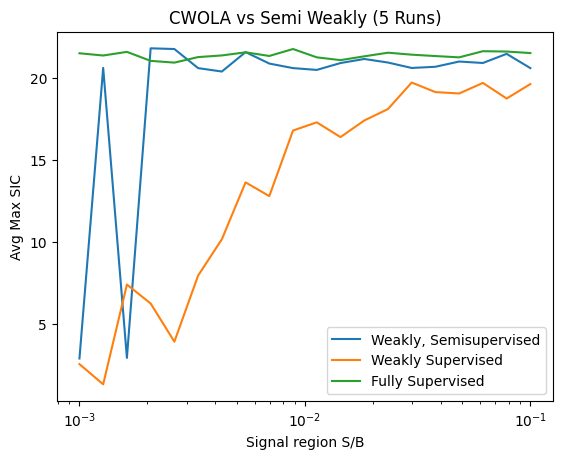

In [78]:
avgmsic1 = np.median(msic1_runs, axis = 0)
avgmsic2 = np.median(msic2_runs, axis = 0)
avgmsic3 = np.median(msic3_runs, axis = 0)

# avgsic1 = np.mean(sic1_list_runs, axis = 0)
# avgsic2 = np.mean(sic2_list_runs, axis = 0)

plt.plot(sig_list,avgmsic1,label="Weakly, Semisupervised")
plt.plot(sig_list,avgmsic2,label="Weakly Supervised")
plt.plot(sig_list,avgmsic3,label="Fully Supervised")
plt.title(f"CWOLA vs Semi Weakly ({num_runs} Runs)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")

(0.0, 700.0)

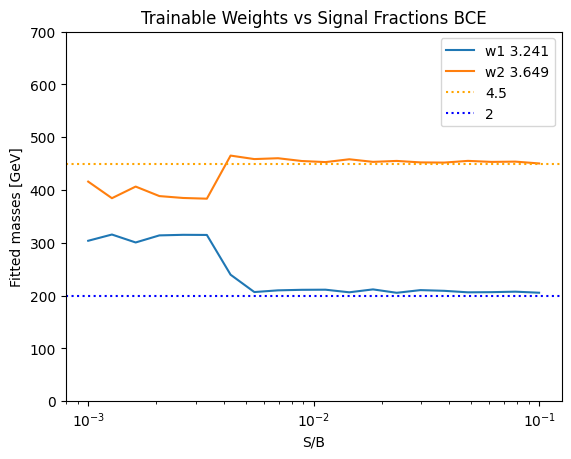

In [36]:
plt.plot(sig_list,np.array(weight_list1)*100, label = f"w1 {w1}")
plt.plot(sig_list,np.array(weight_list2)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions BCE")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])

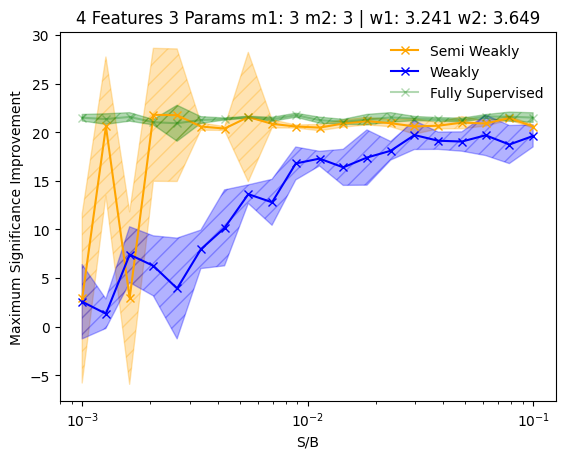

In [79]:
sig_space = np.logspace(-3, -1, 20)
signal_fraction_values = sig_space

maxsic1 = [i[0] for i in avgmsic1]
msicstds1 = np.std(msic1_runs, axis = 0)
maxsicstd1 = np.array([i[0] for i in msicstds1])

maxsic2 = [i[0] for i in avgmsic2]
msicstds2 = np.std(msic2_runs, axis = 0)
maxsicstd2 = np.array([i[0] for i in msicstds2])

maxsic3 = [i[0] for i in avgmsic3]
msicstds3 = np.std(msic3_runs, axis = 0)
maxsicstd3 = np.array([i[0] for i in msicstds3])

plt.plot(signal_fraction_values, maxsic1, marker = "x", label='Semi Weakly', color='orange')
plt.plot(signal_fraction_values, maxsic2, marker = "x", label='Weakly', color='blue')
plt.plot(signal_fraction_values, maxsic3, marker = "x", label='Fully Supervised', color='green', alpha = 0.3)

plt.fill_between(signal_fraction_values, maxsic1 - maxsicstd1, maxsic1 + maxsicstd1, color='orange', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic2 - maxsicstd2, maxsic2 + maxsicstd2, color='blue', alpha=0.3, hatch = "//")
plt.fill_between(signal_fraction_values, maxsic3 - maxsicstd3, maxsic3 + maxsicstd3, color='green', alpha=0.3, hatch = "//")

plt.xlabel('S/B')
plt.ylabel('Maximum Significance Improvement')
plt.title(f'4 Features 3 Params m1: {m1} m2: {m2} | w1: {w1} w2: {w2}')
plt.xscale("log")
plt.legend(frameon= False)
plt.savefig('plot.png', dpi=450, bbox_inches='tight')
plt.show()

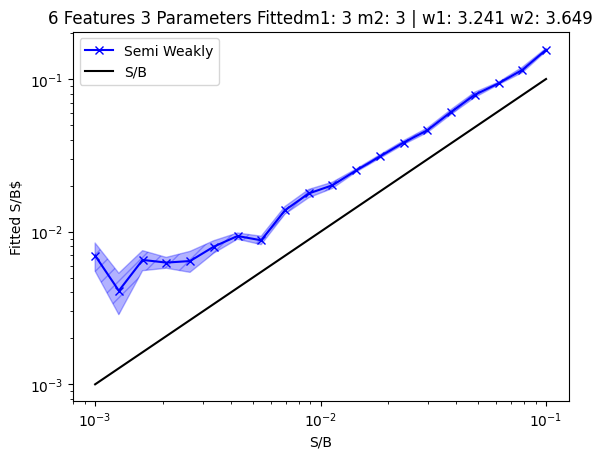

In [80]:
signal_fraction_values = np.logspace(-3, -1, 20)
avgww = np.median(ww_runs, axis = 0)

fittedw = avgww
fittedwstd = np.std(ww_runs, axis = 0)

plt.plot(signal_fraction_values, fittedw, marker = "x", label='Semi Weakly', color='blue')
plt.plot(xx, xx, marker = "", label='S/B', color='black')

plt.fill_between(signal_fraction_values, fittedw - fittedwstd, fittedw + fittedwstd, color='blue', alpha=0.3, hatch = "//")

plt.xlabel('S/B')

plt.ylabel(r'Fitted S/B$')
plt.title(f'6 Features 3 Parameters Fittedm1: {m1} m2: {m2} | w1: {w1} w2: {w2}')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

In [36]:
import time
start_time = time.time()

def create_loss_landscape_4Features(model, m1, m2):
    
    Nfeatures = 4
    #check if loss dictionary exists, if it does load it, if not create empty one
    dir_path = os.getcwd()
    file_name = f"z_{Nfeatures}3param{float(m1)}{float(m2)}.npy"
    file_path = os.path.join(dir_path, file_name)
    
    if os.path.exists(file_path):
        z = np.load(file_name, allow_pickle = True).item()
    else:
        print("Dictionary doesn't exist, creating one...")
        z = {}
    
    losses_list = []

    epsilon = 1e-6
    sig_space = [np.logspace(-3, -1, 20)[-1]]
    
    #if we want a specific sigfrac
    #sig_space = [sig_space[15]]
    
    start = 0.5
    end = 6
    step = 0.25

    weight_list = np.arange(start, end + step, step)
    
    for sig in sig_space:
            
        print("Signal Fraction: ", sig)
        for w1 in weight_list:
            for w2 in weight_list:
                
                #print(w1, w2)
                sigfrac = sig
                
                for l in model.layers:
                    l.trainable=False

                inputs_hold = tf.keras.Input(shape=(1,))
                simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
                model3 = Model(inputs = inputs_hold, outputs = simple_model)

                inputs_hold2 = tf.keras.Input(shape=(1,))
                simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
                model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

                inputs_hold3 = tf.keras.Input(shape=(1,))
                simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
                model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

                inputs = tf.keras.Input(shape=(Nfeatures,))
                inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
                hidden_layer_1 = model(inputs2)
                LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
                #LLR_xs = 1.+sigfrac*LLR - sigfrac
                LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR-model33(tf.ones_like(inputs)[:,0])
                ws = LLR_xs / (1.+LLR_xs+0.0001)
                model_all2 = Model(inputs = inputs, outputs = ws)
                model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

                m1 = m1
                m2 = m2
                
                key = (sig,m1,m2)
                if key in z:
                    break

                test_background = int(1/2 *len(x[0,0]))
                train_background = int(1/4 * len(x[0,0]))
                train_data = int(1/4 * len(x[0,0]))
                train_reference = int(1/4 * len(x[0,0]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2]))
                sig_frac = sigfrac

                #randomize signal events
                #random_test_signal_length = random.randint(0, test_signal_length - 1)
                N = int(1/4 * (len(x[0,0])))
                signal = x[m1, m2][test_signal_length:test_signal_length + int(sigfrac*N)]

                x_data_ = np.concatenate([x[0,0][test_background:],signal])
                y_data_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_data_, y_data_, test_size=0.5, random_state = 42)

                with tf.device('/GPU:4'):
                    loss = model_all2.evaluate(X_val_, Y_val_, verbose = 0)
                losses_list.append(loss)
                
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        print(f"Time taken: {elapsed_time} seconds")
        if key in z:
            print("Landscape for m1 = {} ".format(m1) + "and " + "m2 = {} ".format(m2) +" already exists for " + "{}".format(sigfrac) + " signal fraction")
        else:
            z[sigfrac, m1, m2] = losses_list
            losses_list = []
            np.save(file_name, z)
end_time_total = time.time()

elapsed_time_total = round(end_time_total - start_time, 3)
print(f"Total elapsed time: {elapsed_time_total} seconds")

Total elapsed time: 0.0 seconds


In [16]:
qq = "qq"

In [37]:
create_loss_landscape_4Features(model_all, 3, 3)

Dictionary doesn't exist, creating one...
Signal Fraction:  0.1
Time taken: 666.567 seconds


In [31]:
z.keys()

dict_keys([(0.1, 1, 5.5)])